<a href="https://colab.research.google.com/github/MustafaKhan670093/Machine-Learning-Playbook/blob/master/Image%20Classification%20Using%20A%20CNN%20(CIFAR-10%20Dataset).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Import Libraries**

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

import torch
import numpy as np
from torchvision import datasets, models
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
from torch import optim
import torch.nn as nn
import torch.nn.functional as F

## **Loading Data**

In [2]:
# number of subproccesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# percentage of training data to be used as validation
valid_size = 0.2

# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# choose the training and test datasets
train_data = datasets.CIFAR10(root='data', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10(root='data', train=True, download=True, transform=transform)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders(combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size, num_workers=num_workers)

# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


# print out some data stats
print('Num training images: ', len(train_data))
print('Num test images: ', len(test_data))

Files already downloaded and verified
Files already downloaded and verified
Num training images:  50000
Num test images:  50000


## **Visualize A Batch Of Training Data**

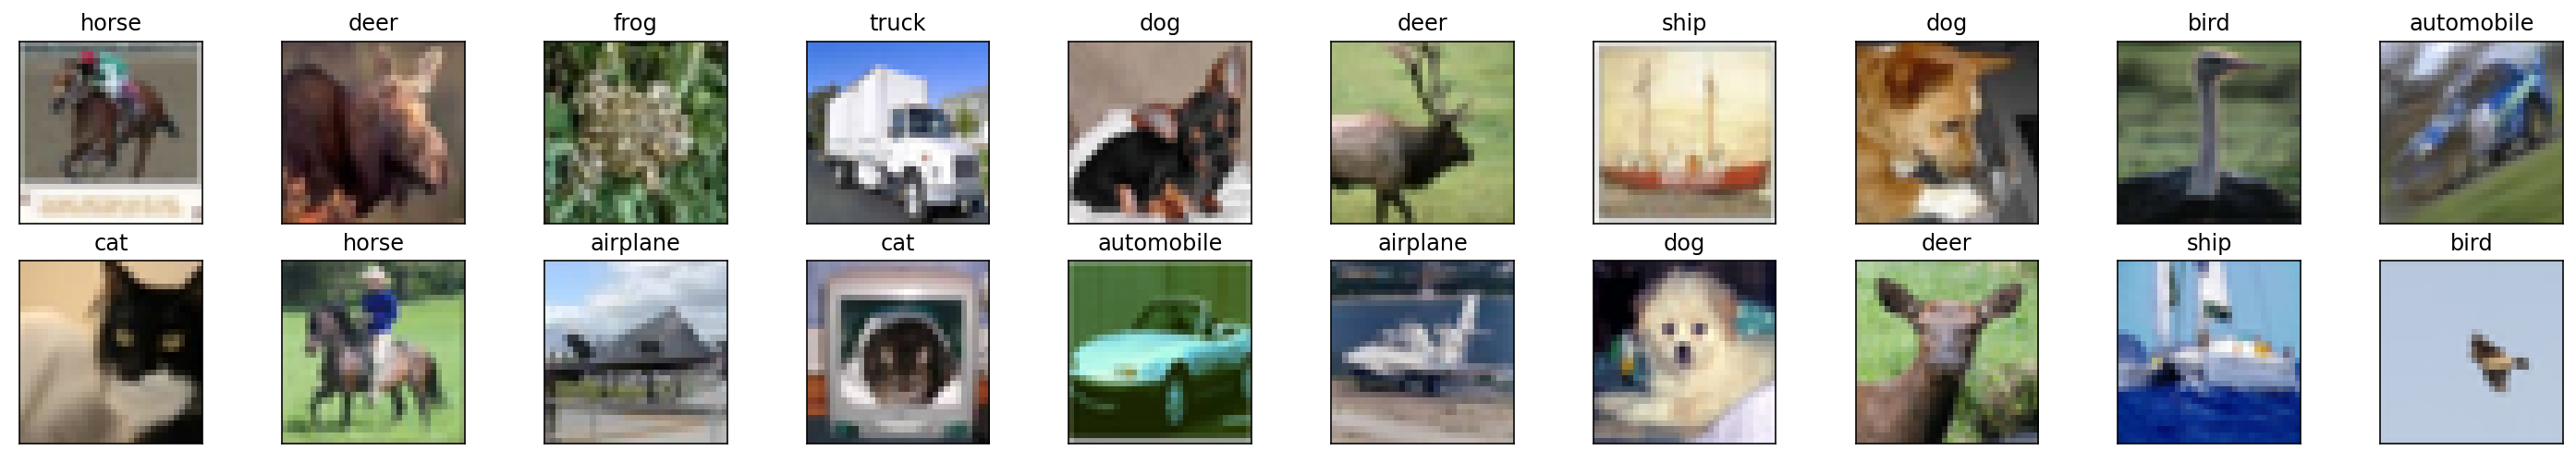

In [3]:
# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

## **View an Image in More Detail**

Here, we look at the normalized red, green, and blue (RGB) color channels as three separate, grayscale intensity images.

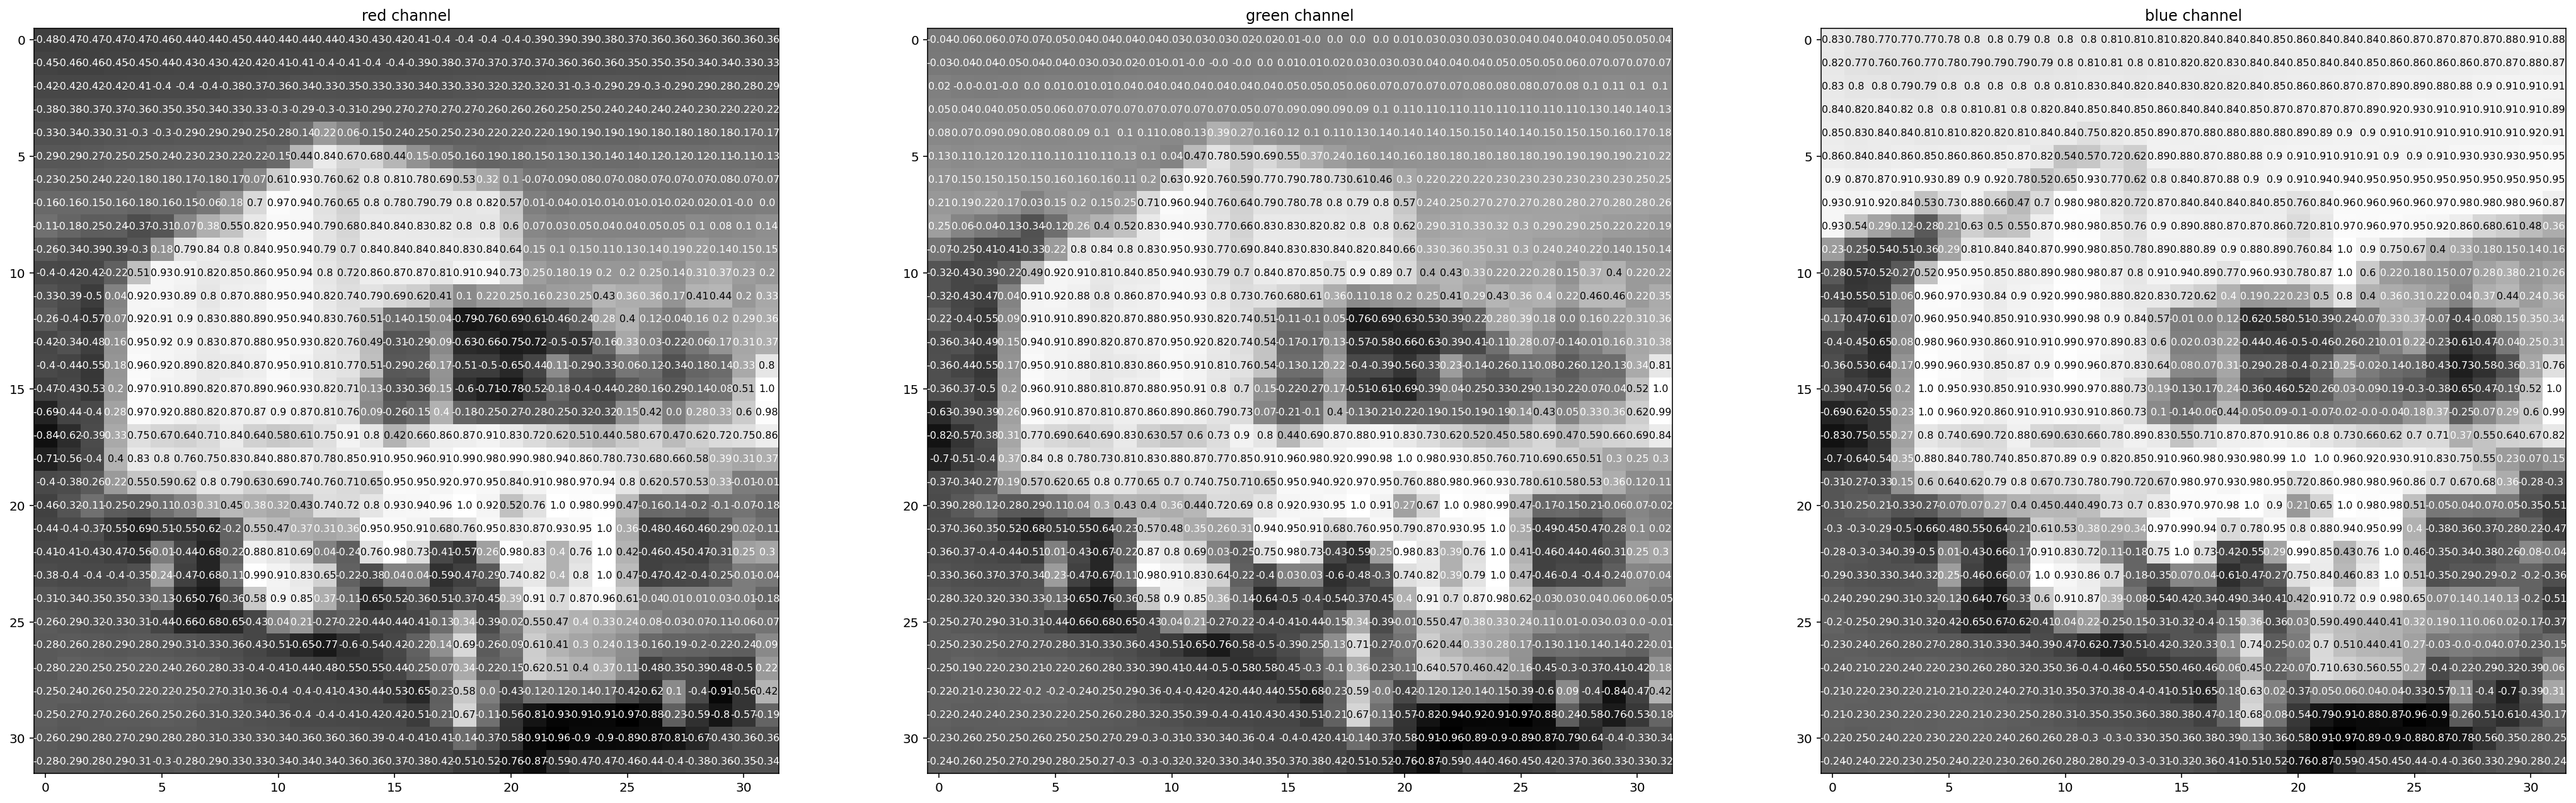

In [4]:
rgb_img = np.squeeze(images[3])
channels = ['red channel', 'green channel', 'blue channel']

fig = plt.figure(figsize = (36, 36)) 
for idx in np.arange(rgb_img.shape[0]):
    ax = fig.add_subplot(1, 3, idx + 1)
    img = rgb_img[idx]
    ax.imshow(img, cmap='gray')
    ax.set_title(channels[idx])
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            val = round(img[x][y],2) if img[x][y] !=0 else 0
            ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center', size=8,
                    color='white' if img[x][y]<thresh else 'black')

## **Checking If GPU Is Available**

In [5]:
# Use GPU if it's available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("The ML code in this project will be trained on " + str(device))

The ML code in this project will be trained on cuda


## **Defining The CNN Architecture**

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        #Note: It is said to keep the kernel_size at 3 until # of filters exceeds 128. Additionally, the in_channel for a CNN is either going to be 1, 3 or 4 depending on if the data is grayscale, coloured or if it has an alpha transparency channel respectively. 
        
        self.cnn_layers = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1), 
                                        nn.BatchNorm2d(num_features=32),  #Said to accelerate training by reducing internal covariate shift (Documentation: https://pytorch.org/docs/master/generated/torch.nn.BatchNorm2d.html and Explanation: https://www.aiworkbox.com/lessons/batchnorm2d-how-to-use-the-batchnorm2d-module-in-pytorch)
                                        nn.ReLU(),
                                        nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),
                                        nn.BatchNorm2d(num_features=32),   
                                        nn.ReLU(),
                                        nn.MaxPool2d(kernel_size=2, stride=2),
                                        nn.Dropout(0.25),
                                        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
                                        nn.BatchNorm2d(num_features=64),
                                        nn.ReLU(),
                                        nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
                                        nn.BatchNorm2d(num_features=64),
                                        nn.ReLU(),
                                        nn.MaxPool2d(kernel_size=2, stride=2),
                                        nn.Dropout(0.25))
                                        #nn.AdaptiveAvgPool2d(output_size=(7, 7)))                               
                                        
        self.linear_layers = nn.Sequential(nn.Linear(64 * 8 * 8, 512),
                                        nn.ReLU(),
                                        nn.Dropout(0.5),
                                        nn.Linear(512, len(classes)),
                                        nn.Softmax(dim=1))
        
    def forward(self, x):        
        x = self.cnn_layers(x)
        # flatten image input
        # print(x.shape) In order to tell what goes into the linear layer as an input, check x.shape
        x = x.view(-1, 64 * 8 * 8)
        x = self.linear_layers(x)
        return x

# initialize the CNN
model = Net()
               
#Sending model to CPU/GPU
model.to(device);

## **Specify Loss Function And Optimizer**

In [7]:
# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optim.SGD(model.parameters(), lr=0.001)

## **A More Detailed Look At The CNN Architecture**

In [8]:
# Find total parameters and trainable parameters
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters exist in the model.')

total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} parameters will be trained.')

#Model architecture
model

2,168,746 total parameters exist in the model.
2,168,746 parameters will be trained.


Net(
  (cnn_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.25, inplace=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Dropout(p=0.25, inplace=F

## **Testing Speed of GPU vs. CPU**

In [9]:
import time

for device in ['cpu', 'cuda']:

    criterion = nn.CrossEntropyLoss()
    
    # Only train the classifier parameters, feature parameters are frozen
    optimizer = optimizer = optim.SGD(model.parameters(), lr=0.01)

    model.to(device)

    for ii, (inputs, labels) in enumerate(train_loader):

        # Move input and label tensors to the GPU
        inputs, labels = inputs.to(device), labels.to(device)

        start = time.time()

        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)
        #The next line of code resolved the following error: RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn
        # loss.requires_grad = True     If you don't get the error, comment out this line.
        loss.backward()
        optimizer.step()

        if ii == 3:
            break

    print(f"Device = {device}; Time per batch: {(time.time() - start) / 3:.3f} seconds")
    
## The above code tests the training speed of the GPU and the CPU 
## by training for 3 iterations and averaging the time it took to complete them. 

Device = cpu; Time per batch: 0.036 seconds
Device = cuda; Time per batch: 0.001 seconds


## **Training The ML Model**

In [10]:
n_epochs = 100
epochs_no_improve = 0
n_epochs_stop = 5

# initialize tracker for minimum validation loss
valid_loss_min = np.Inf # set initial "min" to infinity

for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train() # prep model for training
    for data, target in train_loader:
        # move data and target tensors to the default device
        data, target = data.to(device), target.to(device)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        #The next line of code resolved the following error: RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn
        # loss.requires_grad = True    If you don't get the error, comment out this line.
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval() # prep model for evaluation
    for data, target in valid_loader:
        # move data and target tensors to the default device
        data, target = data.to(device), target.to(device)
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update running validation loss 
        valid_loss += loss.item()*data.size(0)
        
    # print training/validation statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        valid_loss
        ))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss
        epochs_no_improve = 0
    
    else:
        epochs_no_improve += 1
        # Check early stopping condition
        if epochs_no_improve == n_epochs_stop:
            print('Early stopping!')
            break

Epoch: 1 	Training Loss: 2.134528 	Validation Loss: 2.027422
Validation loss decreased (inf --> 2.027422).  Saving model ...
Epoch: 2 	Training Loss: 2.033101 	Validation Loss: 1.982611
Validation loss decreased (2.027422 --> 1.982611).  Saving model ...
Epoch: 3 	Training Loss: 1.998268 	Validation Loss: 1.967067
Validation loss decreased (1.982611 --> 1.967067).  Saving model ...
Epoch: 4 	Training Loss: 1.966902 	Validation Loss: 1.927809
Validation loss decreased (1.967067 --> 1.927809).  Saving model ...
Epoch: 5 	Training Loss: 1.924090 	Validation Loss: 1.892985
Validation loss decreased (1.927809 --> 1.892985).  Saving model ...
Epoch: 6 	Training Loss: 1.896218 	Validation Loss: 1.855235
Validation loss decreased (1.892985 --> 1.855235).  Saving model ...
Epoch: 7 	Training Loss: 1.874797 	Validation Loss: 1.841711
Validation loss decreased (1.855235 --> 1.841711).  Saving model ...
Epoch: 8 	Training Loss: 1.858994 	Validation Loss: 1.842928
Epoch: 9 	Training Loss: 1.846712 

## **Load The Model With The Lowest Validation Loss**

In [14]:
model.load_state_dict(torch.load('model_cifar.pt'))

<All keys matched successfully>

## **Test The Trained Network**

In [15]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() # prep model for evaluation

for data, target in test_loader:
    # move data and target tensors to the default device
    data, target = data.to(device), target.to(device)
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_loader.sampler)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no more training examples left)' % (class_total[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 1.544189

Test Accuracy of     0: 93% (4672/5000)
Test Accuracy of     1: 96% (4824/5000)
Test Accuracy of     2: 86% (4349/5000)
Test Accuracy of     3: 84% (4241/5000)
Test Accuracy of     4: 91% (4597/5000)
Test Accuracy of     5: 86% (4339/5000)
Test Accuracy of     6: 94% (4715/5000)
Test Accuracy of     7: 93% (4667/5000)
Test Accuracy of     8: 95% (4795/5000)
Test Accuracy of     9: 95% (4759/5000)

Test Accuracy (Overall): 91% (45958/50000)


## **Visualize Sample Test Results**

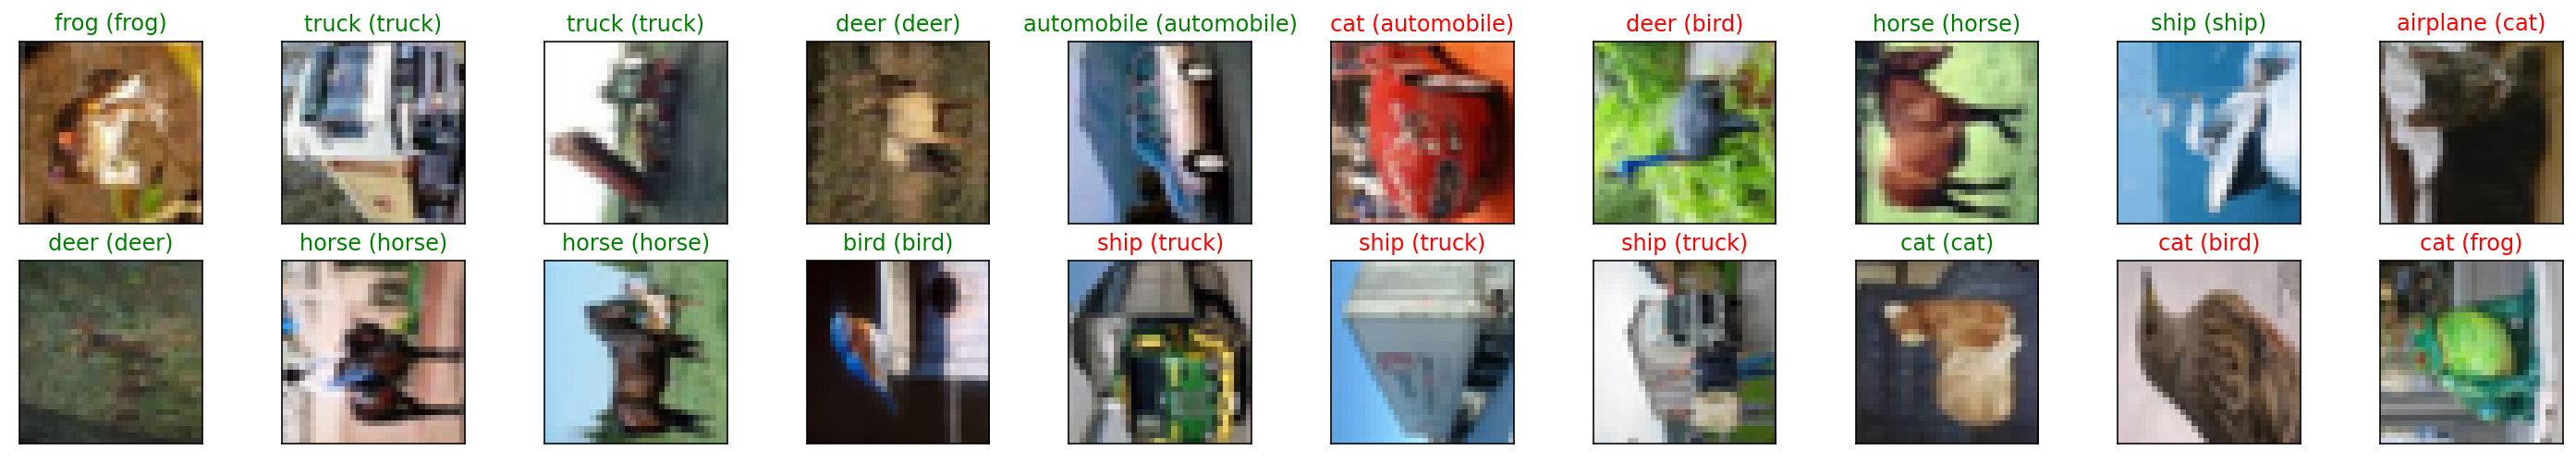

In [16]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images, labels = images.to(device), labels.to(device)

#The following two lines of code avoid clipping input data by normalizing the images first
images -= images.min()
images /= images.max()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.cpu().data.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.transpose(images[idx]), )
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))